# Lorenz system

This time with a bit more deliberate resampling, followed by some analysis.

In [25]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [47]:
# Tender resampling
def lorenz(n, t=None, start=None, alpha=0.01, sigma=10, beta=8/3, rho=28):
    """Generate a sequence of N steps of a Lorenz system, until time=T, 
    starting with START, solved via naive Eurler with step ALPHA."""
    if not start: start = (1,0,1)
    if not t: t = n # Assumping sampling rate of 1
    (x,y,z) = start
    full_n = round(t/alpha)
    history = np.zeros(full_n)    
    for i in range(full_n):
        x,y,z = (x + alpha*sigma*(y - x),
                 y + alpha*(x*(rho-z) - y),
                 z + alpha*(x*y - beta*z))
        history[i] = z    
    return sig.resample(history, n)

lorenz(20)

array([19.05262576, 27.40191143, 17.36924149, 29.93450505, 24.54344864,
       28.76247969, 19.85798458, 26.11239872, 26.99953943, 27.43764008,
       26.14495494, 27.44566964, 24.05728488, 25.33360881, 24.25301112,
       25.57560558, 24.10140309, 25.63800788, 24.09090644, 25.89039184])

In [58]:
# Aggressive resampling (only good for exaggerated rates
def lorenz2(n, t=None, start=None, alpha=0.01, sigma=10, beta=8/3, rho=28):
    """Same with Lorentz, but with naive manual resampling"""
    if not start: start = (1,0,1)
    if not t: t = n # Default sampling of 1
    (x,y,z) = start
    full_n = round(t/alpha*1.1) # With some excess just in case
    rate = t/n                  # Resampling rate
    if rate < alpha:
        raise Exception('Reampling rate is too high, hot supported.')
    history = np.zeros(n)
    (t, j) = (0, 0)         # Starting time and sampling counter
    for i in range(full_n):
        x,y,z = (x + alpha*sigma*(y - x),
                 y + alpha*(x*(rho-z) - y),
                 z + alpha*(x*y - beta*z))
        t += alpha
        if t >= rate:
            history[j] = z
            t += -rate
            j += 1
        if j==n:
            break
    return history

lorenz2(20)

array([19.55892218,  7.57058753, 25.29093863, 29.70919048, 21.96251919,
       30.16225993, 29.39562831, 27.73450382, 25.66768498, 27.91964462,
       26.59872269, 22.98828132, 13.17051751, 29.51138002, 19.02641953,
       37.71820902, 18.03905073, 28.79807477, 27.79138764, 11.51840929])

Node that it is not a real resampling in the DSp sense, but some sort of approximate (and irregular in time!) selection of some points. It probably works OK if `alpha` and `sampling` rate are quite different (α << s), but probably looks very weird if they are similar. Change to a legit approach if there are any issues here.

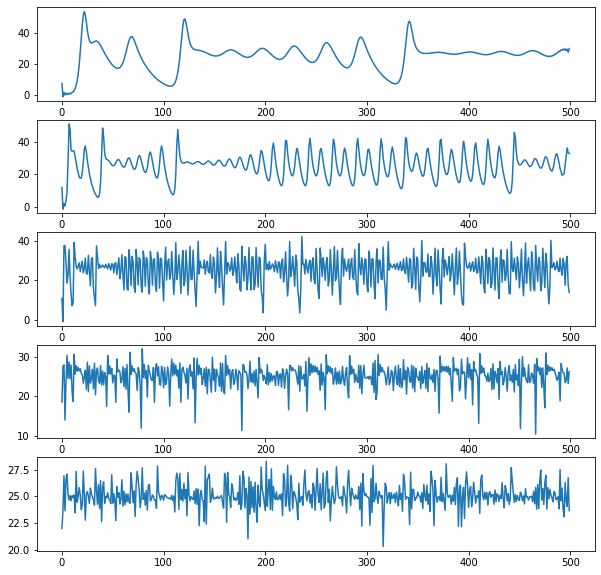

In [51]:
# Compare different scales
plt.figure(figsize=(10,10))
n = 5
times = [10, 30, 100, 300, 1000]
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(lorenz(500, t=times[i]))

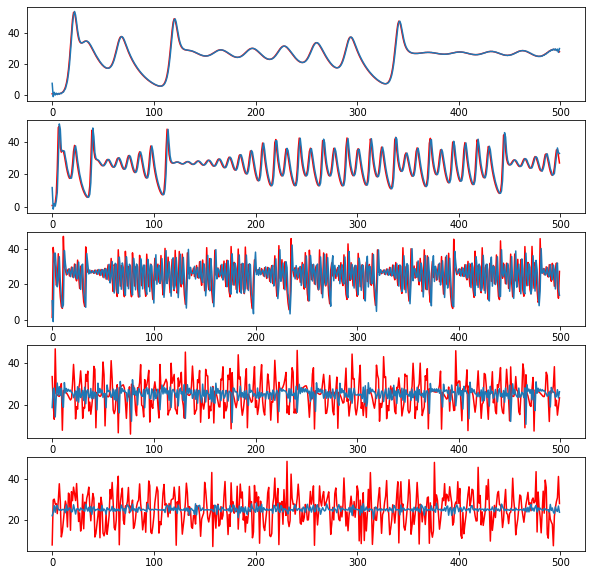

In [54]:
# Compare different samplers
plt.figure(figsize=(10,10))
n = 5
times = [10, 30, 100, 300, 1000]
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(lorenz2(500, t=times[i]), color='red')
    plt.plot(lorenz(500, t=times[i]))

**What can we see here?** That "official" resampling is only good for high sampling rates, and especially when sampling rate is similar to the integration step. For high rates (when a smooth process devolves into random sampling), it is not only memory-wasteful, it also rescales the signal a lot by honest pre-downsampling filtering. That doesn't make sense in this case.

That said, training on so heavily downsampled chaotic trajectories is probably useless (nothing to capture here). In practice we'll probably stick with pretty slow signals.

Still I'm biased towards the "naive resampler".

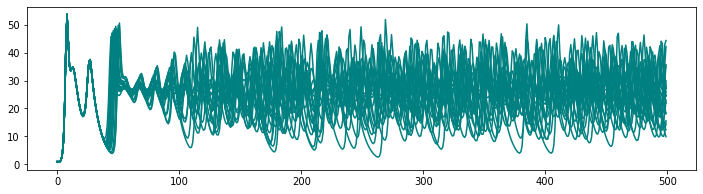

In [24]:
# Instability

plt.figure(figsize=(12,3))
for i in range(20):
    a = 1 + np.random.normal(0, 0.1)
    plt.plot(lorenz(500, sampling=0.05, start=(1,0,a)), color='teal')